#### Loading the nam mini sample dataset

In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('C:\MS CS\Semester3\Big Data\mini-sample.tdv')

#### Top three places that are most likely to be struck by lightning

In [2]:
df.createOrReplaceTempView("nam_table")

places_struck_by_lightning = spark.sql("select Geohash from nam_table where lightning_surface = (SELECT MAX(lightning_surface) FROM nam_table)").collect()
for i in range(3):
    print(places_struck_by_lightning[i])

Row(Geohash='9rj219yu2dzz')
Row(Geohash='bcr0y5yfktzz')
Row(Geohash='dpbmmn08b0eb')


#### Driest Month in Bay Area
November

In [3]:
spark.sql("select from_unixtime(Timestamp, 'MM') as month, avg(relative_humidity_zerodegc_isotherm) as avgHumidity from nam_table where Geohash like '9q%' group by month").show()

+-----+------------------+
|month|       avgHumidity|
+-----+------------------+
|   07| 38.97423737503204|
|   11| 37.84730352472288|
|   01| 39.78702119257602|
|   09| 39.47369882026371|
|   05| 40.01742608198829|
|   08| 40.26419783770349|
|   03| 39.01672745566595|
|   02| 40.26533679464408|
|   06| 39.60947263184204|
|   10|           40.6875|
|   12|38.308930351801735|
|   04| 38.97208515437755|
+-----+------------------+



#### Climate chart around Bay Area

In [73]:
import matplotlib.pyplot as plt
climatechart = spark.sql("select from_unixtime(Timestamp, 'M') as month, max(temperature_surface), min(temperature_surface), avg(precipitable_water_entire_atmosphere), avg(temperature_surface) from nam_table where Geohash like '9q8%' group by from_unixtime(Timestamp, 'M')").collect()
f = open('climatechart','w')
for row in climatechart:
    f.write(str(row['month'])+'\t'+str(row['max(temperature_surface)'])+'\t'+str(row['min(temperature_surface)'])+'\t'+str(row['avg(precipitable_water_entire_atmosphere)'])+'\t'+str(row['avg(temperature_surface)'])+'\n')
f.close()

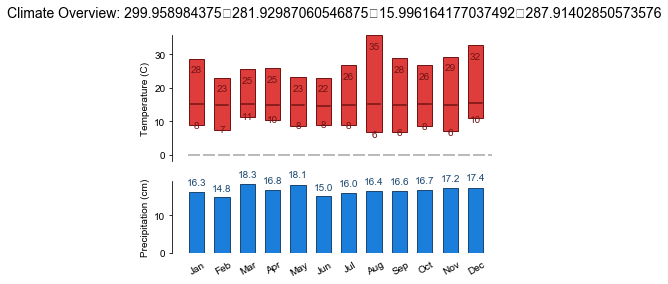

In [74]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc

def c2f(t):
    return (t*9/5.0)+32

def k2c(t):
    return t-273.15

def k2f(t):
    return (t*9/5.0)-459.67

def disable_spines(ax):
    for s in ax.spines:
        ax.spines[s].set_visible(False)

rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

use_c = True
converter = k2f
if use_c:
    converter = k2c

filename = 'C:\MS CS\Semester3\Big Data\p3-d1-binduvasini\climatechart'

with open(filename, 'r') as f:
    first_line = f.readline()[1:].strip()

data = np.loadtxt(fname=filename)
data[:, 0] = data[:, 0] - 1
data[:, 1] = converter(data[:, 1])
data[:, 2] = converter(data[:, 2])
if use_c == False:
    data[:, 3] = data[:, 3] * 0.0393701
data[:, 4] = converter(data[:, 4])

plt.ion()
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(hspace=.20)
gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
plt.setp(ax0.get_xticklabels(), visible=False) # disable upper axis label

ax0.patch.set_facecolor('None')
ax1.patch.set_facecolor('None')

plt.suptitle('Climate Overview: ' + first_line, fontsize=14)

if k2c(data[:, 1]).min() < 5:
    y = 0
    if not use_c:
        y = c2f(0)
    ax0.plot([0, data[:, 0].max() + 1], [y, y], zorder=-1, color='#888888',
            alpha=.75, dashes=(8, 2))

rects0 = ax0.bar(.35 + data[:, 0], data[:, 2] - data[:, 1], bottom=data[:, 1],
        width=.6, color='#df3c3c', edgecolor='#731515')

rects1 = ax1.bar(.35 + data[:, 0], data[:, 3], color='#1b7edb', width=.6,
        edgecolor='#1d4871')

plt.xticks(np.arange(0,12) + .4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    rotation=30)

disable_spines(ax0)
disable_spines(ax1)
ax0.spines['left'].set_visible(True)
ax1.spines['left'].set_visible(True)

for tic in ax0.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax0.yaxis.get_major_ticks():
    tic.tick2On = False

for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax1.yaxis.get_major_ticks():
    tic.tick2On = False

for rect in rects1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
        '%.1f' % (height), ha='center', va='bottom', color='#1d4871')

for r, rect in enumerate(rects0):
    height = rect.get_height()
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 1.08*height,
        '%d' % int(height + rect.get_y()), ha='center', va='bottom',
        color='#731515')
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() - 2,
        '%d' % int(rect.get_y()), ha='center', va='top', color='#731515')
    ax0.plot([rect.get_x() + .05, rect.get_x() + rect.get_width() - .05],
            [data[r, 4], data[r, 4]], color='#731515')

if use_c:
    ax0.set_ylabel('Temperature (C)')
    ax1.set_ylabel('Precipitation (cm)')
else:
    ax0.set_ylabel('Temperature (F)')
    ax1.set_ylabel('Precipitation (in)')

plt.show()

#### Summary Statistics

In [7]:
f = open('features.txt')
for column in df.columns:
    if column != "Timestamp" and column != "Geohash":
        df.describe(column).show()

+-------+------------------------+
|summary|geopotential_height_lltw|
+-------+------------------------+
|  count|                 5404746|
|   mean|       2141.460589701558|
| stddev|      1898.1221123819798|
|    min|              -8015.5312|
|    max|               6202.4365|
+-------+------------------------+

+-------+---------------------------------------+
|summary|water_equiv_of_accum_snow_depth_surface|
+-------+---------------------------------------+
|  count|                                5404746|
|   mean|                      8.035800387291186|
| stddev|                      37.34503968059668|
|    min|                                    0.0|
|    max|                                 5649.0|
+-------+---------------------------------------+

+-------+------------------------+
|summary|drag_coefficient_surface|
+-------+------------------------+
|  count|                 5404746|
|   mean|     0.15554024185410378|
| stddev|       39.85484170219889|
|    min|              

+-------+-----------------+
|summary| pressure_surface|
+-------+-----------------+
|  count|          5404746|
|   mean|97921.93197108616|
| stddev|6044.402231989399|
|    min|          64793.0|
|    max|         105153.0|
+-------+-----------------+

+-------+------------------------------------------------+
|summary|transpiration_stress-onset_soil_moisture_surface|
+-------+------------------------------------------------+
|  count|                                         5404746|
|   mean|                              0.1549934152875891|
| stddev|                             0.16673067708897651|
|    min|                                             0.0|
|    max|                                           0.405|
+-------+------------------------------------------------+

+-------+---------------------+
|summary|soil_porosity_surface|
+-------+---------------------+
|  count|              5404746|
|   mean|  0.23408500602988558|
| stddev|  0.24949293473759912|
|    min|              

+-------+----------------------+
|summary|temperature_tropopause|
+-------+----------------------+
|  count|               5404746|
|   mean|     210.0485875405655|
| stddev|     9.712765499794848|
|    min|             184.60947|
|    max|             260.55334|
+-------+----------------------+

+-------+-------------------------+
|summary|geopotential_height_pblri|
+-------+-------------------------+
|  count|                  5404746|
|   mean|        519.8203549129231|
| stddev|        514.5360938361491|
|    min|                13.405798|
|    max|                 5365.292|
+-------+-------------------------+

+-------+-------------------+
|summary|pressure_tropopause|
+-------+-------------------+
|  count|            5404746|
|   mean| 18644.448375531134|
| stddev| 7533.6550322862095|
|    min|          6653.1465|
|    max|          50103.297|
+-------+-------------------+

+-------+-------------------+
|summary| snow_depth_surface|
+-------+-------------------+
|  count|       

#### Pearson's Correlation coefficient and heatmap

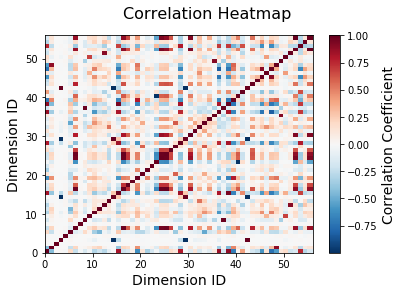

In [8]:
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
import numpy as np
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

raw_data = sc.textFile('C:\MS CS\Semester3\Big Data\mini-sample.tdv')

def parse_interaction(line):
    line_split = line.split("\t")
    symbolic_indexes = [0,1]
    clean_line_split = [item for i,item in enumerate(line_split) if i not in symbolic_indexes]
    return np.array([float(x) for x in clean_line_split])

vector_data = raw_data.map(parse_interaction)
correlation_matrix = Statistics.corr(vector_data, method="pearson")

plt.suptitle('Correlation Heatmap', fontsize=16)
plt.xlabel('Dimension ID', fontsize=14)
plt.ylabel('Dimension ID', fontsize=14)

plt.pcolor(correlation_matrix, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('Correlation Coefficient', fontsize=14)
plt.show()

In [52]:
feats = []
correlationpoints = {}
f = open('features.txt')
for i,feat1 in enumerate(f):
    if i==0 or i==1:
        continue
    feats.append(feat1)

for j, feat2 in enumerate(feats):
    for k, feat3 in enumerate(feats):
        print(feat2.strip(),',',feat3.strip(),':',correlation_matrix[j,k])
        correlationpoints[feat2.strip()+','+feat3.strip()]= correlation_matrix[j,k]
        

geopotential_height_lltw , geopotential_height_lltw : 1.0
geopotential_height_lltw , water_equiv_of_accum_snow_depth_surface : -0.423721220927
geopotential_height_lltw , drag_coefficient_surface : 0.00139085993113
geopotential_height_lltw , sensible_heat_net_flux_surface : 0.0134127562832
geopotential_height_lltw , categorical_ice_pellets_yes1_no0_surface : -0.0197639655107
geopotential_height_lltw , visibility_surface : 0.200286190083
geopotential_height_lltw , number_of_soil_layers_in_root_zone_surface : -0.22773609559
geopotential_height_lltw , categorical_freezing_rain_yes1_no0_surface : -0.0250667731679
geopotential_height_lltw , pressure_reduced_to_msl_msl : -0.15629269861
geopotential_height_lltw , upward_short_wave_rad_flux_surface : -0.032188894016
geopotential_height_lltw , relative_humidity_zerodegc_isotherm : -0.296243224152
geopotential_height_lltw , categorical_snow_yes1_no0_surface : -0.19996537027
geopotential_height_lltw , u-component_of_wind_tropopause : -0.2735263735

visibility_surface , soil_porosity_surface : -0.106770881723
visibility_surface , vegetation_surface : 0.0210586079586
visibility_surface , categorical_rain_yes1_no0_surface : -0.367071424972
visibility_surface , downward_long_wave_rad_flux_surface : 0.0733055250073
visibility_surface , planetary_boundary_layer_height_surface : -0.0191062614926
visibility_surface , soil_type_as_in_zobler_surface : -0.0733778235883
visibility_surface , geopotential_height_cloud_base : -0.115206144927
visibility_surface , friction_velocity_surface : -0.141744355456
visibility_surface , maximumcomposite_radar_reflectivity_entire_atmosphere : -0.50814507257
visibility_surface , plant_canopy_surface_water_surface : -0.203285355548
visibility_surface , v-component_of_wind_maximum_wind : -0.131339005107
visibility_surface , geopotential_height_zerodegc_isotherm : 0.266429622174
visibility_surface , mean_sea_level_pressure_nam_model_reduction_msl : 0.18243174048
visibility_surface , temperature_surface : 0.281

total_cloud_cover_entire_atmosphere , ice_cover_ice1_no_ice0_surface : 0.00650230985697
total_cloud_cover_entire_atmosphere , convective_inhibition_surface : 0.000315839847672
total_cloud_cover_entire_atmosphere , pressure_surface : -0.00136023713917
total_cloud_cover_entire_atmosphere , transpiration_stress-onset_soil_moisture_surface : 0.000406367301513
total_cloud_cover_entire_atmosphere , soil_porosity_surface : 0.000505599215107
total_cloud_cover_entire_atmosphere , vegetation_surface : -0.00510346539217
total_cloud_cover_entire_atmosphere , categorical_rain_yes1_no0_surface : 0.0153886174072
total_cloud_cover_entire_atmosphere , downward_long_wave_rad_flux_surface : 0.230579355914
total_cloud_cover_entire_atmosphere , planetary_boundary_layer_height_surface : 0.999741180237
total_cloud_cover_entire_atmosphere , soil_type_as_in_zobler_surface : 0.000313758137309
total_cloud_cover_entire_atmosphere , geopotential_height_cloud_base : 0.0697329042174
total_cloud_cover_entire_atmosphe

pressure_surface , planetary_boundary_layer_height_surface : -0.00460034795581
pressure_surface , soil_type_as_in_zobler_surface : -0.52798934237
pressure_surface , geopotential_height_cloud_base : -0.00891986391597
pressure_surface , friction_velocity_surface : -0.202705064471
pressure_surface , maximumcomposite_radar_reflectivity_entire_atmosphere : -0.0334259422923
pressure_surface , plant_canopy_surface_water_surface : -0.289146337574
pressure_surface , v-component_of_wind_maximum_wind : -0.00238757915018
pressure_surface , geopotential_height_zerodegc_isotherm : 0.0909771964299
pressure_surface , mean_sea_level_pressure_nam_model_reduction_msl : 0.19229264227
pressure_surface , temperature_surface : 0.207925887533
pressure_surface , snow_cover_surface : -0.201894386022
pressure_surface , geopotential_height_surface : -0.991179099044
pressure_surface , convective_available_potential_energy_surface : 0.164392573921
pressure_surface , latent_heat_net_flux_surface : 0.00168619326327
p

friction_velocity_surface , lightning_surface : 0.0658665320644
friction_velocity_surface , ice_cover_ice1_no_ice0_surface : -0.047735455952
friction_velocity_surface , convective_inhibition_surface : 0.0684271314889
friction_velocity_surface , pressure_surface : -0.202705064471
friction_velocity_surface , transpiration_stress-onset_soil_moisture_surface : 0.364214551269
friction_velocity_surface , soil_porosity_surface : 0.372186927557
friction_velocity_surface , vegetation_surface : 0.276043419539
friction_velocity_surface , categorical_rain_yes1_no0_surface : 0.130672712928
friction_velocity_surface , downward_long_wave_rad_flux_surface : -0.134586513778
friction_velocity_surface , planetary_boundary_layer_height_surface : 0.0623101021739
friction_velocity_surface , soil_type_as_in_zobler_surface : 0.277251728166
friction_velocity_surface , geopotential_height_cloud_base : 0.0881412187835
friction_velocity_surface , friction_velocity_surface : 1.0
friction_velocity_surface , maximum

geopotential_height_surface , plant_canopy_surface_water_surface : 0.269889127859
geopotential_height_surface , v-component_of_wind_maximum_wind : -0.029118671793
geopotential_height_surface , geopotential_height_zerodegc_isotherm : -0.0653227493196
geopotential_height_surface , mean_sea_level_pressure_nam_model_reduction_msl : -0.0782665682688
geopotential_height_surface , temperature_surface : -0.193447340665
geopotential_height_surface , snow_cover_surface : 0.182052456359
geopotential_height_surface , geopotential_height_surface : 1.0
geopotential_height_surface , convective_available_potential_energy_surface : -0.165740075205
geopotential_height_surface , latent_heat_net_flux_surface : -0.000591792742211
geopotential_height_surface , surface_roughness_surface : 0.278726897872
geopotential_height_surface , pressure_maximum_wind : 0.0065984970011
geopotential_height_surface , temperature_tropopause : 0.122252078046
geopotential_height_surface , geopotential_height_pblri : 0.04037409

downward_short_wave_rad_flux_surface , convective_inhibition_surface : 0.0241392161171
downward_short_wave_rad_flux_surface , pressure_surface : -0.00157545366307
downward_short_wave_rad_flux_surface , transpiration_stress-onset_soil_moisture_surface : -0.0259034998522
downward_short_wave_rad_flux_surface , soil_porosity_surface : -0.0268051556143
downward_short_wave_rad_flux_surface , vegetation_surface : 0.0620190899456
downward_short_wave_rad_flux_surface , categorical_rain_yes1_no0_surface : -0.0755768651789
downward_short_wave_rad_flux_surface , downward_long_wave_rad_flux_surface : 0.136800233973
downward_short_wave_rad_flux_surface , planetary_boundary_layer_height_surface : 0.0370005991026
downward_short_wave_rad_flux_surface , soil_type_as_in_zobler_surface : -0.0153078681228
downward_short_wave_rad_flux_surface , geopotential_height_cloud_base : -0.0437221616959
downward_short_wave_rad_flux_surface , friction_velocity_surface : 0.192281057972
downward_short_wave_rad_flux_surf

In [55]:
for key in correlationpoints:
    if correlationpoints[key] > 0.7 and correlationpoints[key] < 0.9:
        print(key, ':', correlationpoints[key])

geopotential_height_lltw,upward_long_wave_rad_flux_surface : 0.828170146483
geopotential_height_lltw,downward_long_wave_rad_flux_surface : 0.801472580507
geopotential_height_lltw,geopotential_height_zerodegc_isotherm : 0.866249297318
geopotential_height_lltw,temperature_surface : 0.884142747242
geopotential_height_lltw,precipitable_water_entire_atmosphere : 0.75445016018
water_equiv_of_accum_snow_depth_surface,snow_depth_surface : 0.888788711642
number_of_soil_layers_in_root_zone_surface,soil_type_as_in_zobler_surface : 0.789034885136
number_of_soil_layers_in_root_zone_surface,surface_roughness_surface : 0.766138031513
number_of_soil_layers_in_root_zone_surface,wilting_point_surface : 0.859440746719
number_of_soil_layers_in_root_zone_surface,direct_evaporation_cease_soil_moisture_surface : 0.859440746719
upward_long_wave_rad_flux_surface,geopotential_height_lltw : 0.828170146483
upward_long_wave_rad_flux_surface,downward_long_wave_rad_flux_surface : 0.84651489616
upward_long_wave_rad_f

In [9]:
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    ["geopotential_height_lltw", 
         "downward_long_wave_rad_flux_surface", 
         "geopotential_height_zerodegc_isotherm", 
         "temperature_surface"],
    "precipitable_water_entire_atmosphere")

#prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])
trainingData.show()

+--------------------+---------+
|            features|    label|
+--------------------+---------+
|[-6284.79296875,1...|1.2307758|
|[-5931.79296875,1...|1.4807758|
|[-5847.078125,129...|1.1537673|
|[-5702.078125,133...|1.2787673|
|[-5655.04296875,1...|1.4807758|
|[-5629.54296875,1...|1.4807758|
|[-5623.19921875,1...|1.2137284|
|[-5620.04296875,1...|1.4807758|
|[-5611.79296875,1...|1.7307758|
|[-5606.90234375,1...| 1.322402|
|[-5604.04296875,1...|1.4807758|
|[-5599.29296875,1...|1.4807758|
|[-5593.29296875,1...|1.7307758|
|[-5591.19921875,1...|1.4637284|
|[-5550.828125,139...|1.0287673|
|[-5548.29296875,1...|1.7307758|
|[-5545.8125,145.3...|1.9408569|
|[-5538.94921875,1...|1.4637284|
|[-5522.8125,144.5...|1.6908569|
|[-5515.69921875,1...|1.7137284|
+--------------------+---------+
only showing top 20 rows



In [10]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.72267


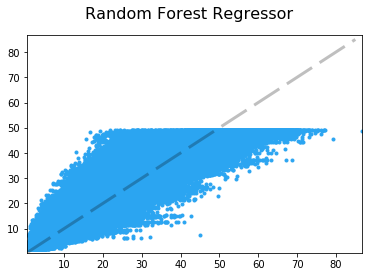

In [11]:
import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

#### Average humidity in the Bay Area

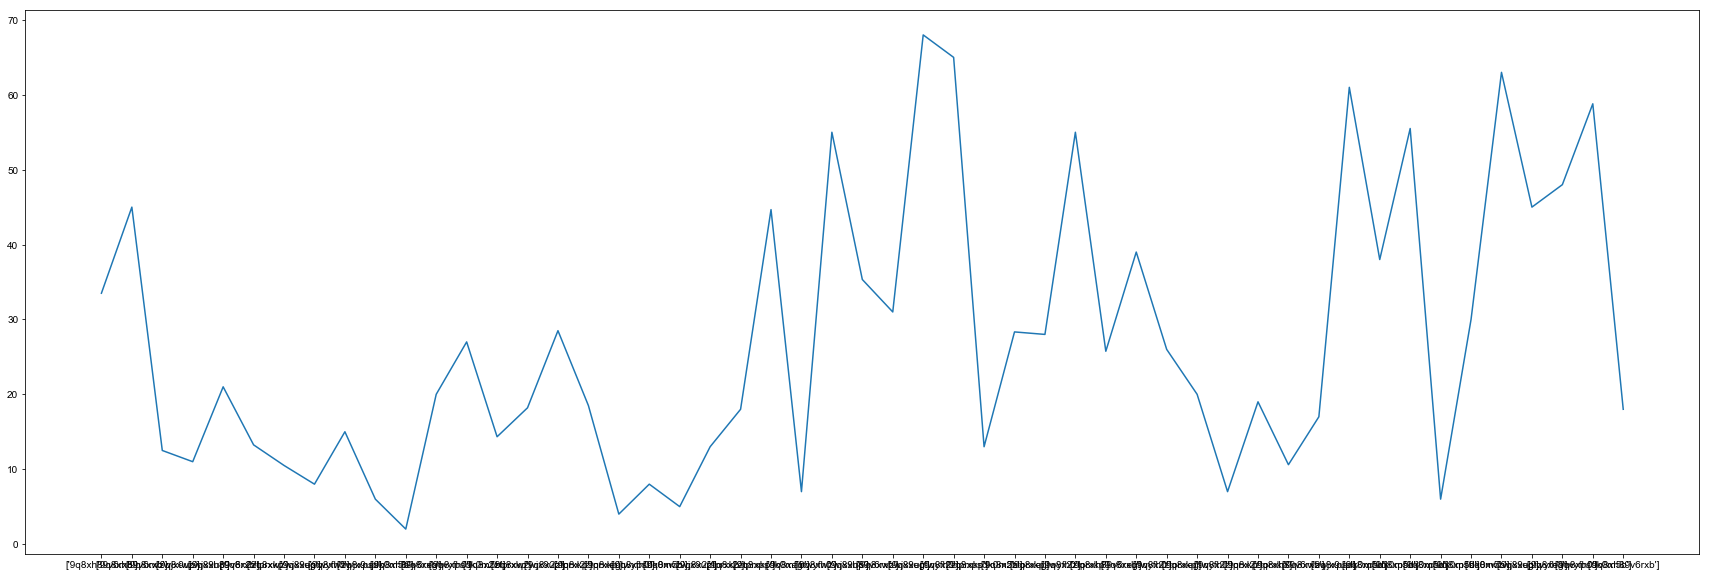

In [133]:
import matplotlib.pyplot as plt
import numpy as np

bayarea_humidity = spark.sql("select Geohash, avg(relative_humidity_zerodegc_isotherm) as avgHumidity from nam_table group by from_unixtime(Timestamp, 'MM'), Geohash having Geohash like '9q8x%'")

geohash_array_indices = []
geohash_array = []

for i in range(bayarea_humidity.select(bayarea_humidity.Geohash).count()):
    geohash_array_indices.append(i)
    
geohash_array = np.asarray(bayarea_humidity.select(bayarea_humidity.Geohash).collect())

x = np.asarray(geohash_array_indices)
y = np.asarray(bayarea_humidity.select(bayarea_humidity.avgHumidity).collect())
plt.figure(figsize=(30,10))
plt.xticks(x, geohash_array)
plt.plot(x, y)
plt.show()